# Importing Libraries and Reading Data

In [140]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

In [2]:
def fill_missing(series, limit):
    series = series.astype('str')
    series = ['0' + i if len(i) < limit else i for i in series]
    return series

In [52]:
df1 = pd.read_csv('https://blueprintdata2020.s3-us-west-1.amazonaws.com/DataSet1.csv')
df1['county'] = fill_missing(df1['county'], 5)
df1['state'] = fill_missing(df1['state'], 2)
df3 = pd.read_csv('https://blueprintdata2020.s3-us-west-1.amazonaws.com/DataSet3.csv')
df4 = pd.read_csv('https://blueprintdata2020.s3-us-west-1.amazonaws.com/DataSet4.csv')
df4['state_code'] = fill_missing(df4['state_code'], 2)
df5 = pd.read_csv('https://blueprintdata2020.s3-us-west-1.amazonaws.com/DataSet5old.csv')
df5['state'] = fill_missing(df5['state'], 2)
strictness = pd.read_csv('https://blueprintdata2020.s3-us-west-1.amazonaws.com/state_strictness.csv')
population = pd.read_csv('https://blueprintdata2020.s3-us-west-1.amazonaws.com/population.csv')
population = population.drop(33, axis = 0)
population['state_code'] = fill_missing(population['state_code'].astype('int'), 2)
wba = pd.read_csv('https://blueprintdata2020.s3-us-west-1.amazonaws.com/white_black_asian.csv')
wba['fibs'] = fill_missing(wba['fibs'].astype('int64'), 12)
marital = pd.read_csv('https://blueprintdata2020.s3-us-west-1.amazonaws.com/marital_status.csv')
marital['fibs'] = fill_missing(marital['fibs'].astype('int64'), 12)

# Data Cleaning and Preprocessing

In [53]:
wba['fibs'] = [str(i)[0:2] for i in wba['fibs']]
wba = wba[['fibs', 'white', 'black', 'asian']].groupby('fibs').agg('sum')
wba = wba.reset_index()
marital['fibs'] = [str(i)[0:2] for i in marital['fibs']]
marital = marital[['fibs', 'single', 'married']].groupby('fibs').agg('sum')
marital = marital.reset_index()
demographics = wba.merge(marital, left_on = 'fibs', right_on = 'fibs', how = 'inner')
demographics.head()

,fibs,white,black,asian,single,married
0,01,3400118,1320276,77731,1119862,1976820
1,02,538969,37800,58279,163298,290469
2,04,5424677,358764,268095,1601160,2639451
3,05,2367649,484170,51277,597296,1248745
4,06,25159975,2723286,6122435,10443182,15163543


In [54]:
df5 = df5.drop_duplicates('state', keep = 'last')
df5 = df5[['state', 'cases_y']].merge(population[['state_code', 'Pop']], left_on = 'state', right_on = 'state_code', how = 'inner')
df5['per_capita'] = [df5.at[i, 'cases_y'] * 100000 / df5.at[i, 'Pop'] for i in range(len(df5))]
df5.head()

,state,cases_y,state_code,Pop,per_capita
0,01,177064,01,4908620,3607.205284
1,02,12790,02,734002,1742.502064
2,04,234914,04,7378490,3183.767953
3,05,102798,05,3039000,3382.625864
4,06,896424,06,39937500,2244.567136


In [57]:
df4 = df4[list(df4.columns[0:10]) + ['state_code']]
train = df5.merge(df4, left_on = 'state_code', right_on = 'state_code', how = "inner")
test = train['per_capita']
state = train['state']
pop = train['Pop']
train = train.drop(['state', 'cases_y', 'state_code', 'Pop', 'Location', 'per_capita'], axis = 1)
train = train.apply(LabelEncoder().fit_transform)
train['state'] = state
train['Pop'] = pop
train = train.merge(demographics, left_on = 'state', right_on = 'fibs', how = 'inner')
train['white'] = [train.at[i, 'white'] / train.at[i, 'Pop'] for i in range(len(train))]
train['black'] = [train.at[i, 'black'] / train.at[i, 'Pop'] for i in range(len(train))]
train['asian'] = [train.at[i, 'asian'] / train.at[i, 'Pop'] for i in range(len(train))]
train['single'] = [train.at[i, 'single'] / train.at[i, 'Pop'] for i in range(len(train))]
train['married'] = [train.at[i, 'married'] / train.at[i, 'Pop'] for i in range(len(train))]
train = train.drop(['state', 'fibs', 'Pop'], axis = 1)
train.head()

,Status of Reopening,Stay at Home Order,Mandatory Quarantine for Travelers,Non-Essential Business Closures,Large Gatherings Ban,Restaurant Limits,Bar Closures,Face Covering Requirement,Emergency Declaration,white,black,asian,single,married
0,1,1,0,2,4,2,3,4,0,0.692683,0.268971,0.015836,0.228142,0.402724
1,2,1,1,1,4,2,3,2,0,0.734288,0.051498,0.079399,0.222476,0.395733
2,0,1,4,3,5,1,2,3,0,0.735202,0.048623,0.036335,0.217004,0.357722
3,1,0,4,0,4,3,3,4,0,0.779088,0.159319,0.016873,0.196544,0.410907
4,2,3,0,3,1,3,2,4,0,0.629984,0.068189,0.153300,0.261488,0.379682


In [58]:
train.isnull().values.any()

False

In [59]:
test.isnull().values.any()

False

In [85]:
def evaluate(rf):
    predictions = rf.predict(test_features)
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(test_labels, predictions))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_labels, predictions))
    print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(test_labels, predictions)))
    mape = np.mean(np.abs((test_labels - predictions) / np.abs(test_labels)))
    print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
    print('Accuracy:', round(100*(1 - mape), 2))

In [122]:
train_features, test_features, train_labels, test_labels = train_test_split(train, test, test_size = 0.25, random_state = 42)

# Modeling and Hyperparameter Tuning

Random Forest was used because it works well with nonlinear data, is robust to outliers, is resistant to overfitting, and handles various forms of data well.

In [126]:
rf = RandomForestRegressor(random_state = 42)
default = rf.fit(train_features, train_labels)

evaluate(default)

Mean Absolute Error (MAE): 535.4272493810832
Mean Squared Error (MSE): 393605.3500263353
Root Mean Squared Error (RMSE): 627.379749455093
Mean Absolute Percentage Error (MAPE): 18.89
Accuracy: 81.11


In [125]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators.append(100)
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 500, cv = 5, verbose = 2, random_state=42, n_jobs = -1)
rf_random.fit(train_features, train_labels)
best_random = rf_random.best_estimator_
evaluate(best_random)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  6.0min


Mean Absolute Error (MAE): 550.8440170761686
Mean Squared Error (MSE): 449979.84480843885
Root Mean Squared Error (RMSE): 670.8053702889079
Mean Absolute Percentage Error (MAPE): 19.39
Accuracy: 80.61


[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  7.6min finished


In [127]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 100}

In [129]:
param_grid = {
    'max_depth': [10, 30, 50, 70, 90],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, verbose = 2, n_jobs = -1)
grid_search.fit(train_features, train_labels)
best_grid = grid_search.best_estimator_
evaluate(best_grid)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  1.8min


Mean Absolute Error (MAE): 589.7500553147695
Mean Squared Error (MSE): 500146.15179868223
Root Mean Squared Error (RMSE): 707.2101185635584
Mean Absolute Percentage Error (MAPE): 20.68
Accuracy: 79.32


[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  2.2min finished


In [130]:
grid_search.best_params_

{'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

# Feature Importance

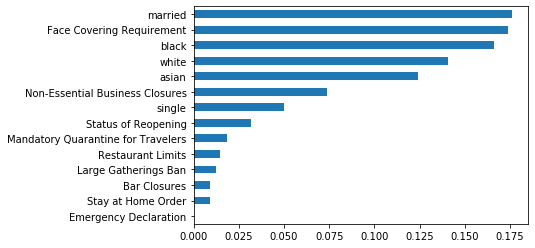

In [131]:
feat_importances = pd.Series(default.feature_importances_, index=train.columns)
feat_importances.sort_values().plot(kind='barh')

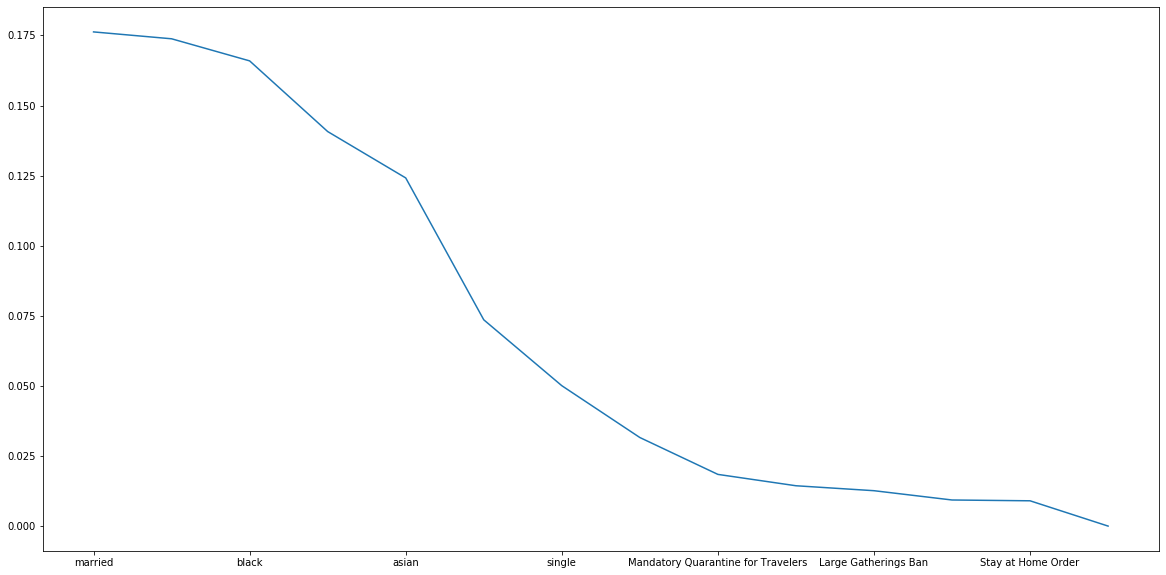

In [135]:
feat_importances.nlargest(len(feat_importances)).plot(kind='line', figsize = (20, 10))

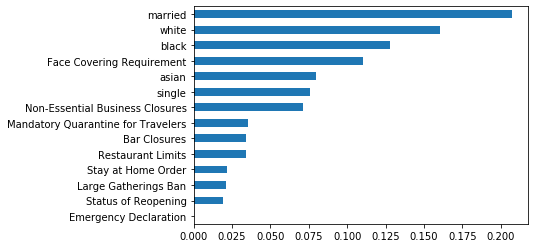

In [136]:
feat_importances = pd.Series(best_random.feature_importances_, index=train.columns)
feat_importances.sort_values().plot(kind='barh')

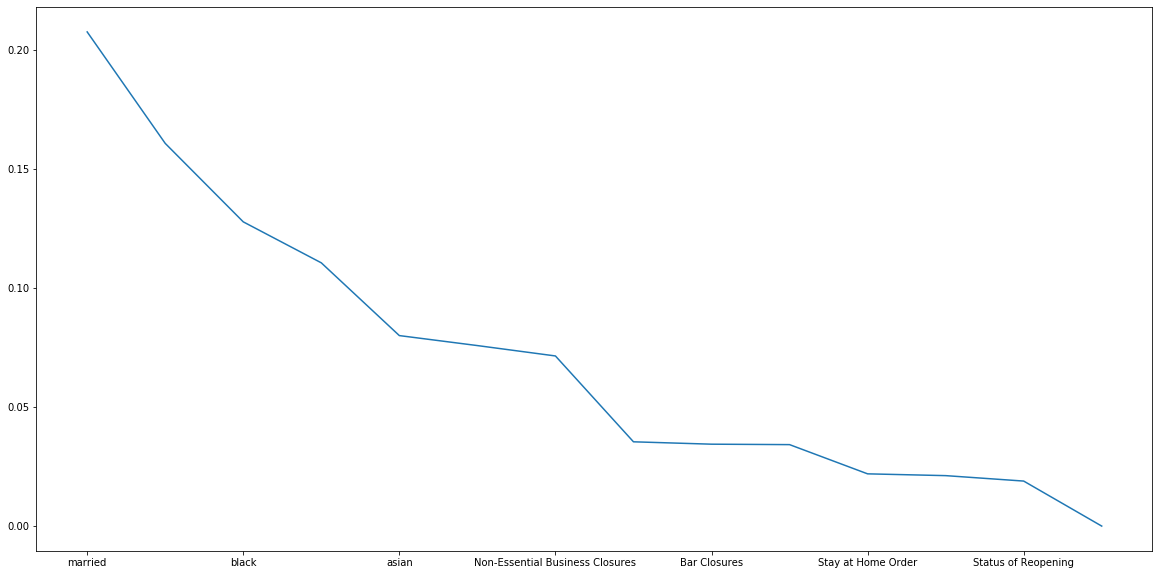

In [137]:
feat_importances.nlargest(len(feat_importances)).plot(kind='line', figsize = (20, 10))

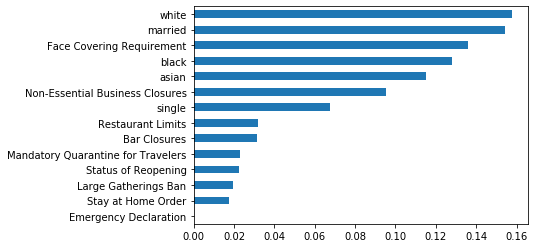

In [138]:
feat_importances = pd.Series(best_grid.feature_importances_, index=train.columns)
feat_importances.sort_values().plot(kind='barh')

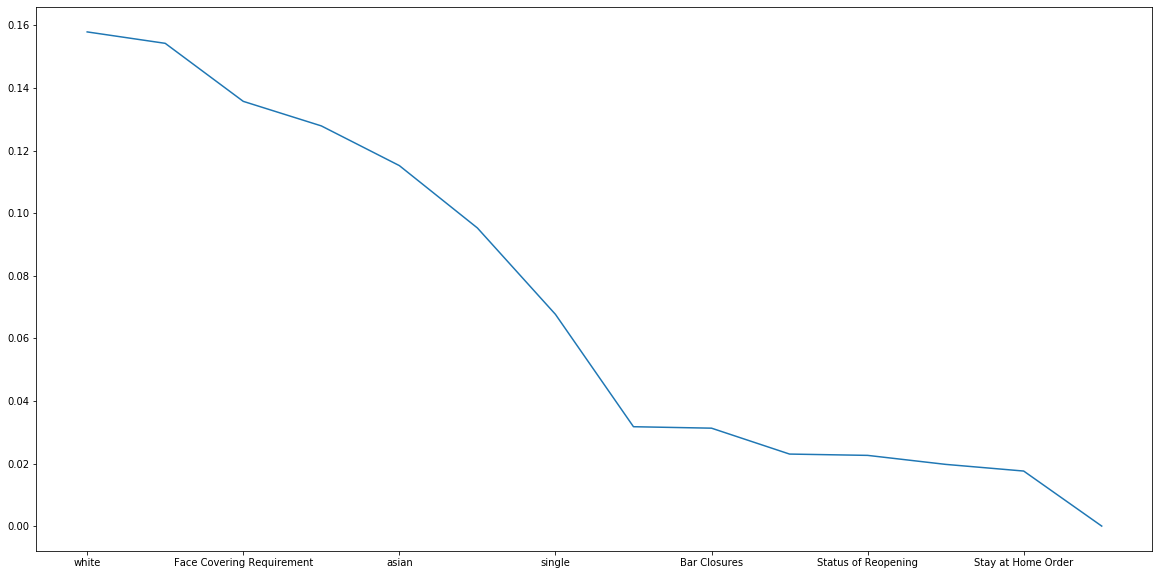

In [139]:
feat_importances.nlargest(len(feat_importances)).plot(kind='line', figsize = (20, 10))